Importing necessary libraries

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
#from sklearn.preprocessing import StandardScaler

from keras.utils import plot_model
from tensorflow.keras.metrics import Recall
#from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall
#from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

import pickle

# The Dataset



HAM10000_metadata.csv file is the main csv file that includes the data of all training images, the features of which are -
1. Lesion_id
2. Image_id
3. Dx
4.  Dx_type
5.  Age
6.  Sex
7.  Localization



In [2]:
# Reading the data from HAM_metadata.csv
df = pd.read_csv('./archive/HAM10000_metadata.csv')

In [3]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [5]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


A statistical analysis of numerical attributes of the dataset (age)

### Data Cleaning and Management

Removing NULL values from the dataset

In [6]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

There are 57 NULL values in 'age' feature.
Rather than dropping the values, replacing NULL values with the mean of 'age'.

In [7]:
df['age'].fillna( df['age'].mean()  , inplace = True)

In [8]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

All NULL values are now resolved.

Now, Making a lesion type dictionary to map the lesion type to a dataframe column.

In [9]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

base_skin_dir = './archive'

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [10]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./archive\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./archive\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./archive\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./archive\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./archive\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2


Finding the number of images for every disease

In [20]:
column_name = 'cell_type'

# Count occurrences of unique values
value_counts = df[column_name].value_counts()

# Print the result
print(value_counts)

cell_type
Melanocytic nevi                  6630
Melanoma                          1113
Benign keratosis-like lesions     1084
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   138
Dermatofibroma                     115
Name: count, dtype: int64


# Image Preprocessing

We have to resize the images from dimensions : 400 * 600 * 3 to dimensions : 125 * 100 * 3 as the model might take a lot of time to run on large dimensions of images.

In [11]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

Plotting some images from each class of dataset.

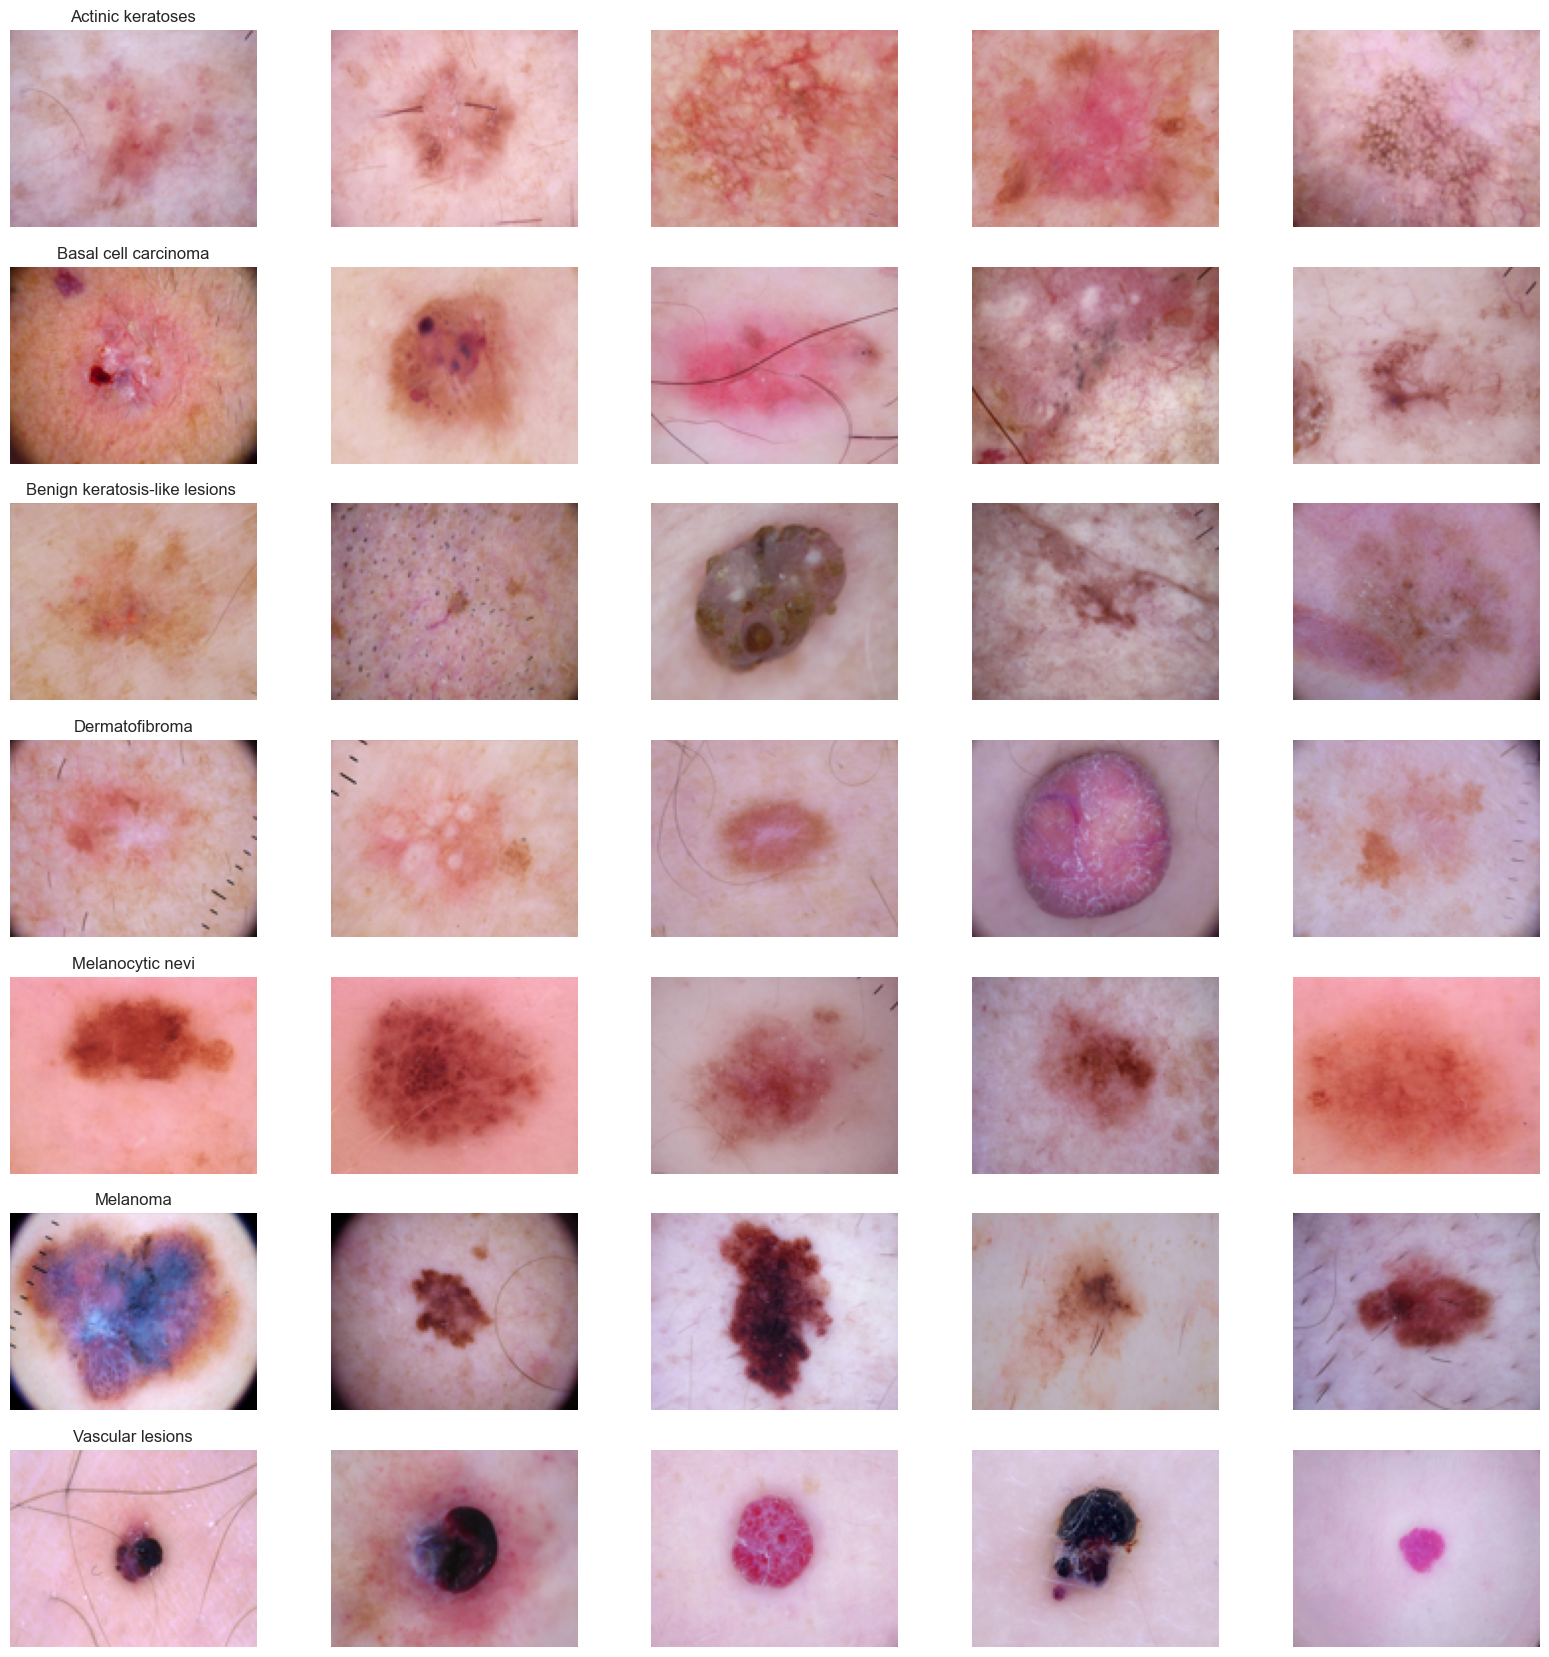

In [12]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [13]:
# to check the image size distribution - It returns one row that shows all images are uniform
df['image'].map(lambda x: x.shape).value_counts()

image
(100, 125, 3)    10015
Name: count, dtype: int64

# Exploratory Data Analysis

Exploratory data analysis can help detect obvious errors, identify outliers in datasets, understand relationships, unearth important factors, find patterns within data, and provide new insights.

In [14]:
df= df[df['age'] != 0]
df= df[df['sex'] != 'unknown']

UNIVARIATE ANALYSIS

<Axes: title={'center': 'CELL TYPE'}, xlabel='cell_type', ylabel='Count'>

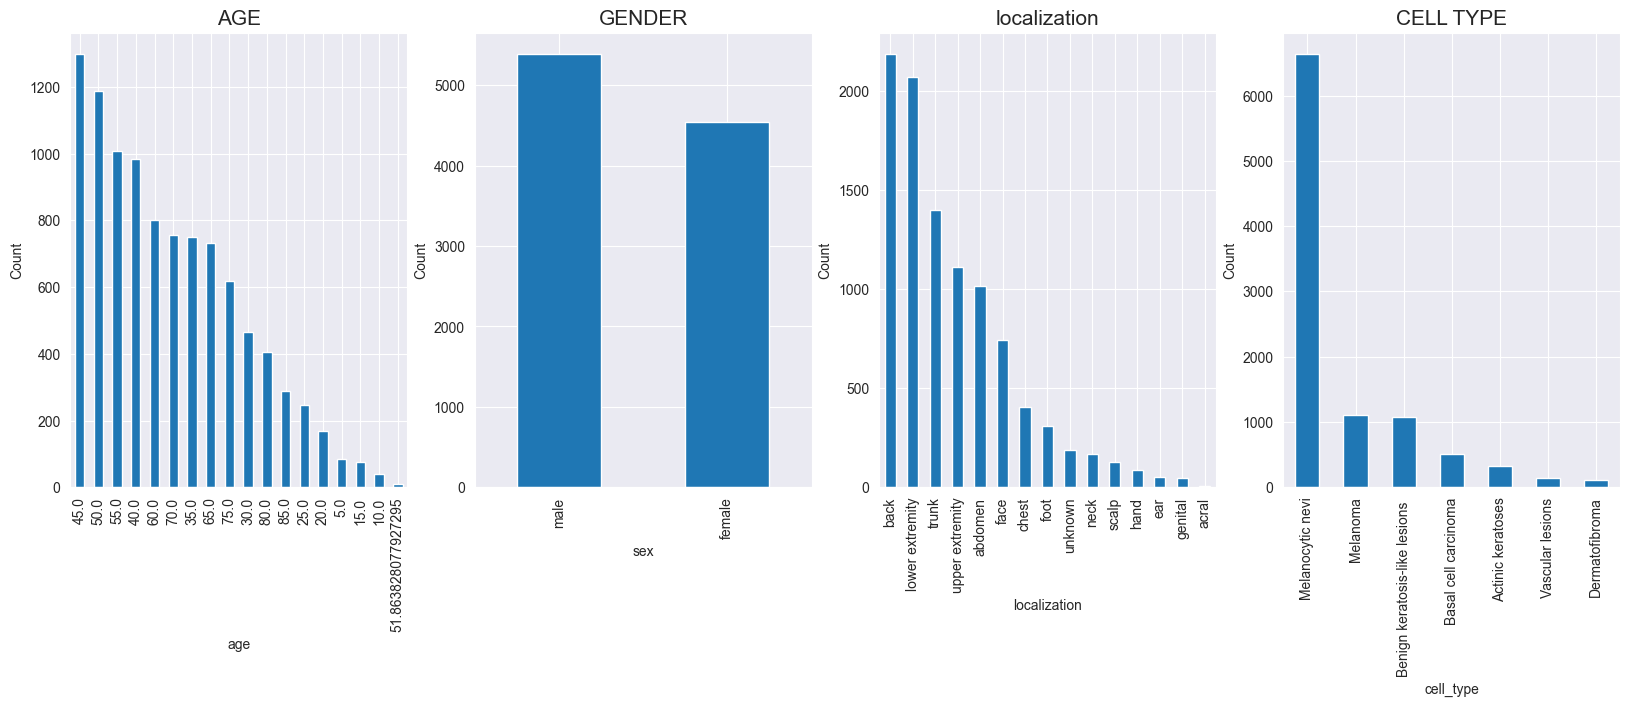

In [15]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
df['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
df['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
df['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
df['cell_type'].value_counts().plot.bar()

1. Skin diseases are found to be maximum in people aged around 45. Minimum for 10 and below. 
2. We also observe that the probability of having skin disease increases with the increase in age.
3. Skin diseases are more prominent in Men as compared to Women and other gender.
4. Skin diseases are more visible on the "back" of the body and least on the "acral surfaces"(such as limbs, fingers, or ears).
5. The most found disease among people is Melanocytic nevi while the least found is Dermatofibroma.

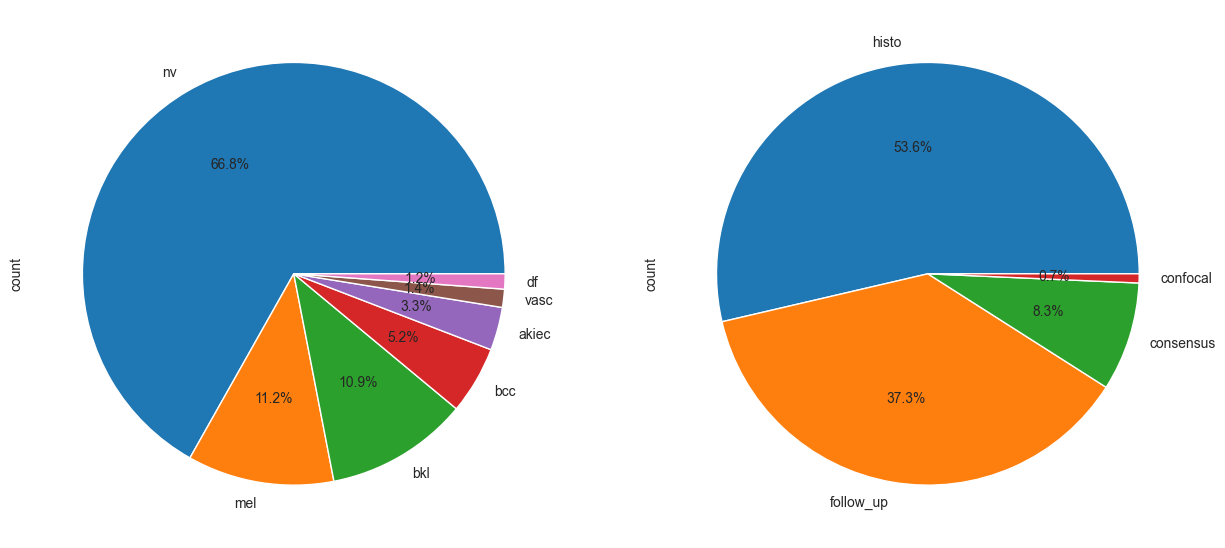

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
df['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
df['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

Type of skin disease:

1. nv: Melanocytic nevi - 69.9%
2. mel: Melanoma - 11.1 %
3. bkl: Benign keratosis-like lesions - 11.0%
4. bcc: Basal cell carcinoma - 5.1%
5. akiec: Actinic keratoses- 3.3%
6. vasc: Vascular lesions-1.4%
7. df: Dermatofibroma - 1.1%

How the skin disease was discovered:

1. histo - histopathology - 53.3%
2. follow_up - follow up examination - 37.0%
3. consensus - expert consensus - 9.0%
4. confocal - confirmation by in-vivo confocal microscopy - 0.7%

BIVARIATE ANALYSIS

<Axes: title={'center': 'LOCALIZATION VS GENDER'}, xlabel='count', ylabel='localization'>

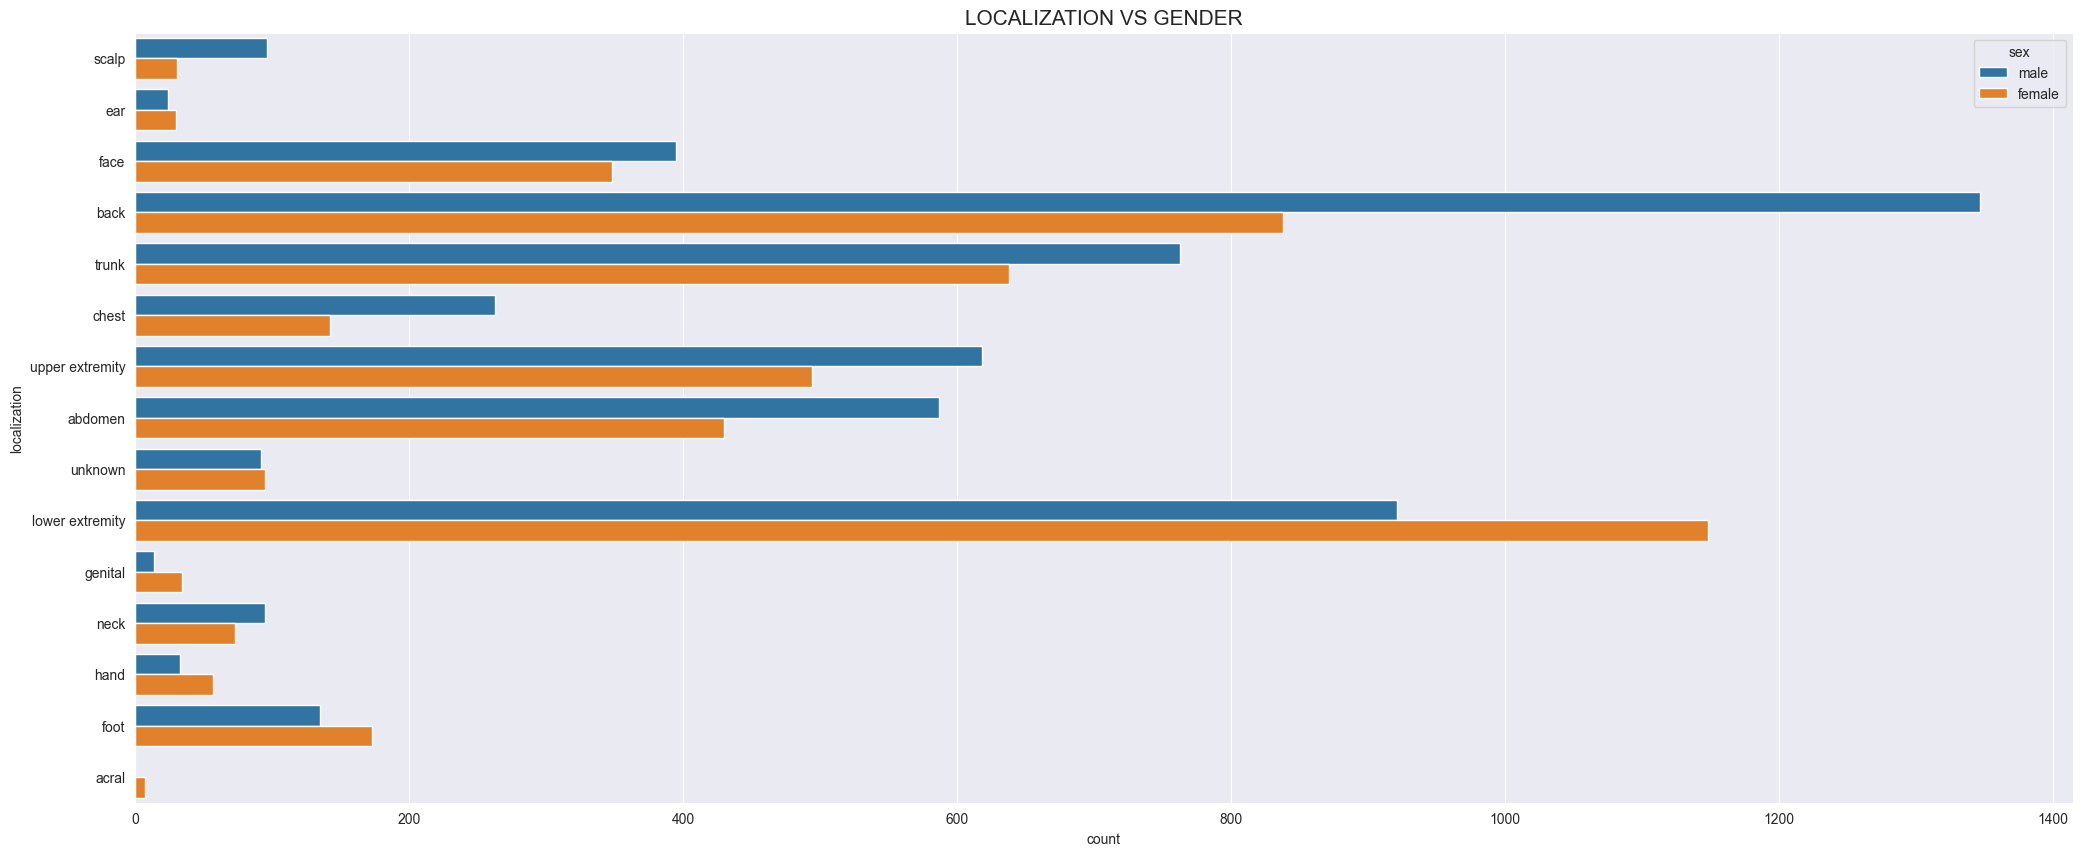

In [17]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS GENDER',fontsize = 15)
sns.countplot(y='localization', hue='sex',data=df)

1. Back are is the most affected among people and more prominent in men.
2. Infection on Lower extremity of the body is more visible in women.
3. Some unknown regions also show infections and it's visible in men, women and other genders.
4. The acral surfaces show the least infection cases that too in men only. Other gender groups don't show this kind of infection.

<Axes: title={'center': 'LOCALIZATION VS CELL TYPE'}, xlabel='count', ylabel='localization'>

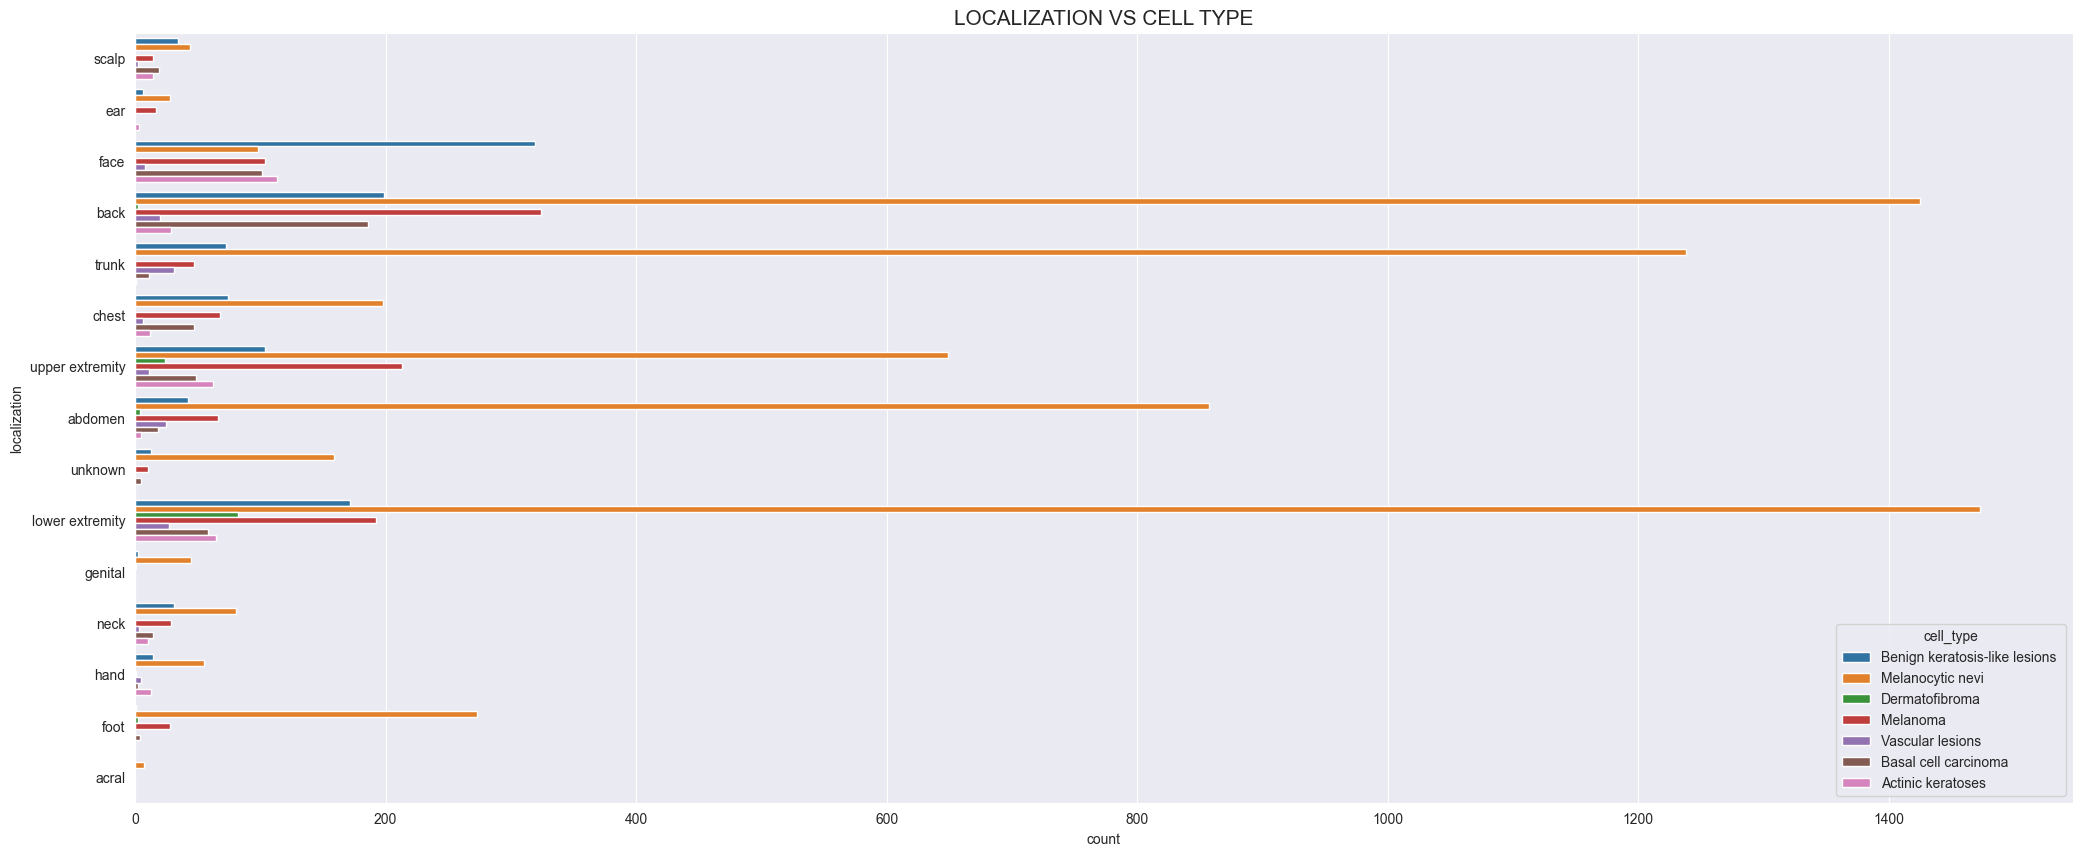

In [18]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS CELL TYPE',fontsize = 15)
sns.countplot(y='localization', hue='cell_type',data=df)

1. The face is infected the most by Benign keratosis-like lesions.
2. Body parts(except face) are infected the most by Melanocytic nevi.

<Axes: title={'center': 'GENDER VS CELL TYPE'}, xlabel='count', ylabel='sex'>

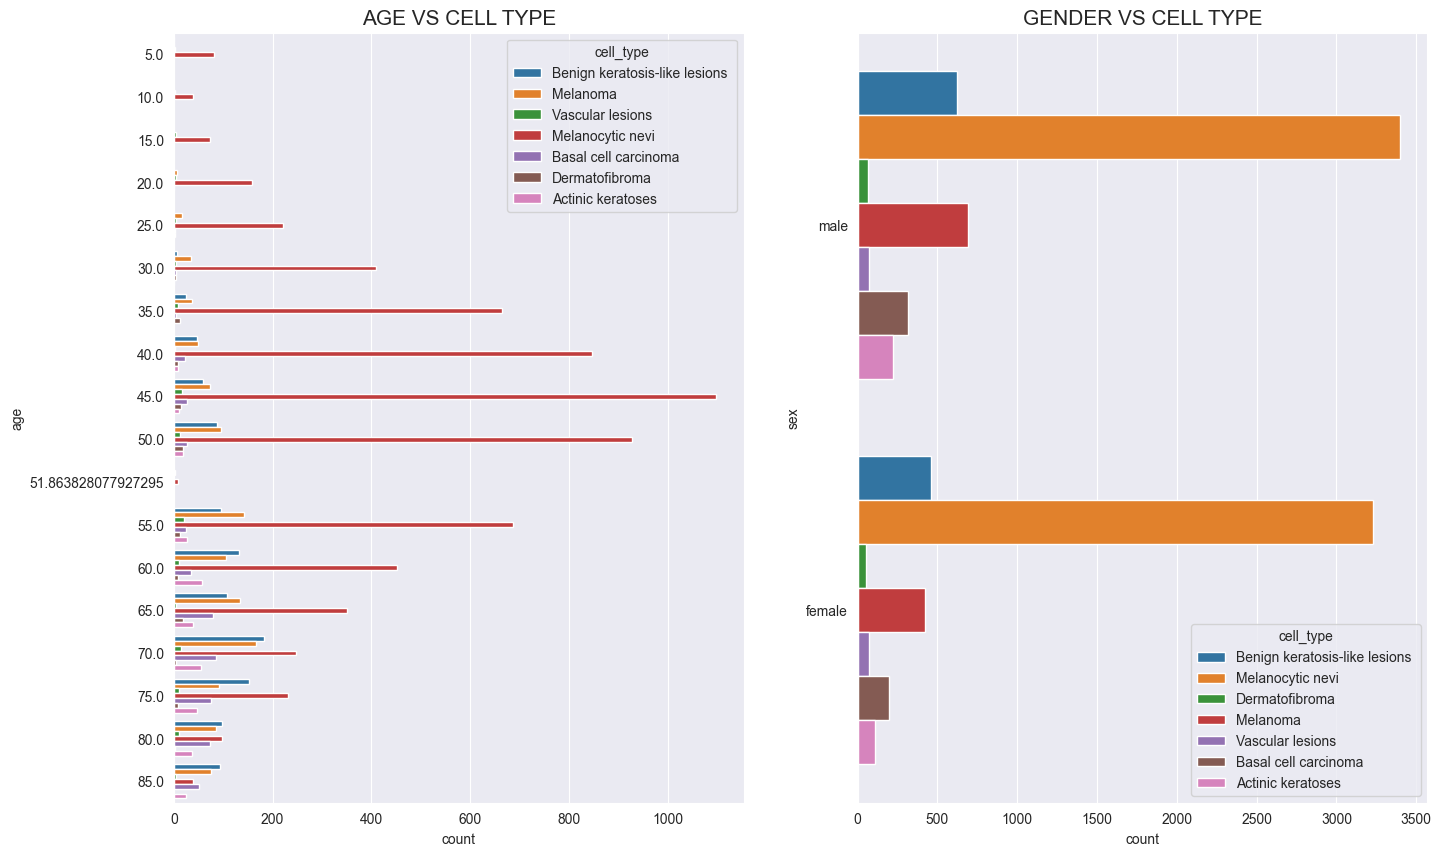

In [19]:
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.title('AGE VS CELL TYPE',fontsize = 15)
sns.countplot(y='age', hue='cell_type',data=df)
plt.subplot(132)
plt.title('GENDER VS CELL TYPE',fontsize = 15)
sns.countplot(y='sex', hue='cell_type',data=df)

1. The age group between 0-75 years is infected the most by Melanocytic nevi. On the other hand, the people aged 80-90 are affected more by Benign keratosis-like lesions.

2. All the gender groups are affected the most by Melanocytic nevi.

# Implementation of ANN

A simple neural network to record patterns in images.

In [21]:
features = df.drop(columns = ['cell_type_idx'], axis = 1)
target = df['cell_type_idx']

features.head()

In [22]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

In [23]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [24]:
# Performing one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_test

In [25]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)

# Reshaping images in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))

In [26]:
np.ma.shape(x_train)

In [27]:
np.ma.shape(x_test)

In [20]:
x_train = x_train.reshape( 6759, 125*100*3)
x_test = x_test.reshape( 2504, 125*100*3)
print(x_train.shape)
print(x_test.shape)

In [21]:
# defining the ANN keras model
model = Sequential()

model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu', input_dim = 37500))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

# compiling the model
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# fitting model on the dataset
history = model.fit(x_train, y_train, batch_size = 10, epochs = 50)

accuracy = model.evaluate(x_test, y_test, verbose=1)[1]
print("Test: accuracy = ",accuracy*100,"%")

In [3]:
#saving the model as a pickle file
import pickle

ann_model_file = "ann_model.pkl"

with open(ann_model_file, 'wb') as file:
    pickle.dump(model, file)

In [31]:
#loading the model from the pickle file
ann_model = pickle.load(open('./ann_model.pkl', 'rb'))

In [36]:
from keras.utils import plot_model

ann_model_png = './ann_model_plot.png'
keras.utils.plot_model(model, to_file=ann_model_png, show_shapes=True, show_layer_names=True)

The average accuracy of ANN model is around 70%.

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')